# Evaluation of Generative Models


In this notebook, we aim to answer the question: How can we evaluate the quality of the synthetic data generated by generative models?

As we know, in discriminative models, such as those used for time series forecasting, the evaluation process is relatively straightforward. For example, we might train a model to answer questions like:

- Given the sequence of the last 7 days of SPY returns, what is the expected value of tomorrow’s SPY return?
- Given the sequence of the last 7 days of SPY returns, what is the probability that tomorrow’s SPY return will be positive?

To evaluate such a model, we simply use a holdout (out-of-sample) dataset and compare the model’s predictions to the true, realized values using appropriate metrics. If the model predicts expected returns, we might use Root Mean Squared Error (RMSE), R-squared, or similar regression metrics. If the model outputs probabilities, we might evaluate it using accuracy, AUC, precision/recall, or other classification metrics.

However, evaluating generative models, which produce synthetic data, is fundamentally different. The data generated by these models is stochastic, meaning that conditioning on the same input can yield different outputs each time. This raises the question: How do we measure the quality of such models on generation tasks?

In this notebook, we’ll walk through the main evaluation criteria used in our experiments that assess the quality of synthetic data generated by these models. These criteria are based on a combination of our own practical experience and commonly used metrics from research papers on generative models.

## How to assess the quality of synthetic data generated by GenAI models?

When evaluating the quality of generated time series data, we focus on some of criterias used in the [TimeGAN](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf) work by Yoon et al. (2019), a model we will explore in the Chapter 08 notebooks:

- **Diversity**: Generated samples should cover the distribution of the real data.

- **Fidelity**: Generated samples should be realistic and indistinguishable from real data.

- **Predictivity**: Synthetic data should be useful for downstream tasks. For example, a model trained on synthetic data should ideally generalize well when evaluated on real data.

In our experience building practical solutions with synthetic data, predictivity is one of the most valuable evaluation strategies. A common approach is to apply **data augmentation**, where we train a downstream model using a mix of real and generated data, and observe whether the model’s performance improves.

So, below we’ll go through an example to illustrate how each criterion is computed.


## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
# Standard library
import os
import random

# Third-party libraries
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset


# Local application imports
from genai4t.data.processing import split_timeseries_with_length, dataset_to_pandas
from genai4t.utils import set_random_state
from genai4t.plot_style import plot_style

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        'random_state': 2024,
        'use_cuda': True
    }

DATA_CONFIG = {
        'name':  "gatam4t/genai4t_exchange_rate",
        'sequence_len': 20,
    }

In [3]:
set_random_state(ENV_CONFIG["random_state"])

Seed set to 2024


## Load Data

For this experiment, we’ll use the **Exchange Rate** dataset—a multivariate time series dataset commonly used in academic benchmarks for forecasting models. It consists of daily exchange rates for eight currencies (Australia, United Kingdom, Canada, Switzerland, China, Japan, New Zealand, and Singapore)

This dataset was one of the benchmarks used in the evaluation of the **Chronos** paper, and is originally available through the Hugging Face Datasets Hub:

🔗 [Original Source (Chronos)](https://huggingface.co/datasets/autogluon/chronos_datasets/viewer/exchange_rate)

To make access easier and ensure long-term reproducibility, a copy of the dataset has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use the Exchange Rate dataset here, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset)

# Display the first few rows of the DataFrame
data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [5]:
# let's work with the currency 1 time series
ts_name = "currency_1"

In [6]:
ts = data[ts_name]

In [7]:
ts.head()

timestamp
1990-01-01    0.7855
1990-01-02    0.7818
1990-01-03    0.7867
1990-01-04    0.7860
1990-01-05    0.7849
Name: currency_1, dtype: float32

In [8]:
# since we will be using DL models, we want to normalize the time series to have mean 0 and std 1
ts = (ts - ts.mean()) / ts.std()

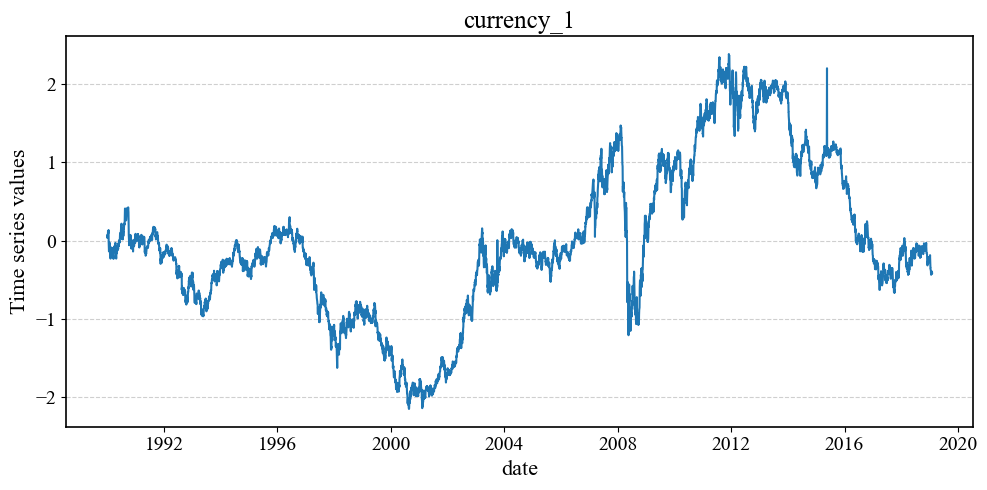

In [9]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_xlabel("date")
ax.set_ylabel("Time series values")
ax.set_title(f"{ts_name}")

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)

## Sequence Generation

Our models will generate new time series of fixed length `sequence_len`, so we need to transform our historical data into this format. We accomplish this by using the `split_timeseries_with_length` function.

In [10]:
ts_as_array = ts.to_numpy()

In [11]:
ts_as_array[: 5]

array([0.0624093 , 0.03532683, 0.07119291, 0.06606925, 0.05801772],
      dtype=float32)

In [12]:
seq_len = DATA_CONFIG['sequence_len']

In [13]:
sequences = split_timeseries_with_length(ts, seq_len)

In [14]:
sequences.shape

(7569, 20)

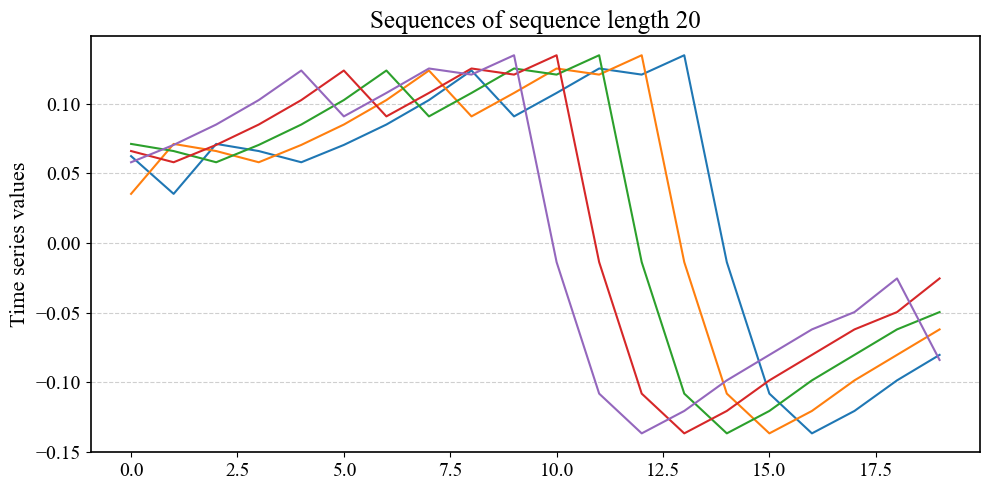

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(5):
    ax.plot(sequences[i], label=f'sequence #{i}')
ax.set_ylabel("Time series values")
ax.set_title(f"Sequences of sequence length {seq_len}")
plot_style.apply_grid(ax)
plot_style.apply_plot_style(ax)
plt.show()

## Generative Model

As a simple case to illustrate the evaluation metrics we’ll be using throughout the notebooks, we’ll focus on a set of toy and intentionally unrealistic generative models. Our "generative model" will simply produce noisy versions of the real data, with varying levels of noise. This setup allows us to isolate and explore how different evaluation metrics behave, without worrying about the complexity of actual generative modeling.

In the later notebooks, we’ll use this same evaluation procedure but applied to synthetic data generated by real generative models we’re testing.

For this toy setup, we’ll take real time series data from a selected currency series and add different levels of Gaussian noise to it.


In [16]:
# Define different noise levels (standard deviations) to test
alphas = [0.1, 0.3, .6]

In [17]:
alphas

[0.1, 0.3, 0.6]

In [18]:
# Generate synthetic data by adding Gaussian noise at different levels to the sequences
synthetic_data = np.zeros((len(alphas), *sequences.shape), dtype=sequences.dtype)
for i, alpha in enumerate(alphas):
    z = np.random.randn(*sequences.shape).astype(sequences.dtype)
    synthetic_data[i] = sequences + alpha * z    

### Visualization

Let’s take a look at some synthetic samples compared to the real data across different noise levels. This will help us to see how each level of noise affects the generated sequences.

In [19]:
from typing import List
def plot_real_and_synthetic(
    real_data: np.ndarray,
    synthetic_data: np.ndarray,
    alphas: List[float]):
    f, ax = plt.subplots(figsize=(10, 3))
    _ = ax.plot(real_data, label='real')
    for i, alpha in enumerate(alphas):
        ax.plot(synthetic_data[i], label=f'alpha={alpha:0.3}', alpha=0.6)
    ax.legend();
    ax.set_title("Real vs Synthetic Data")
    plot_style.apply_plot_style(ax)
    plot_style.apply_grid(ax)

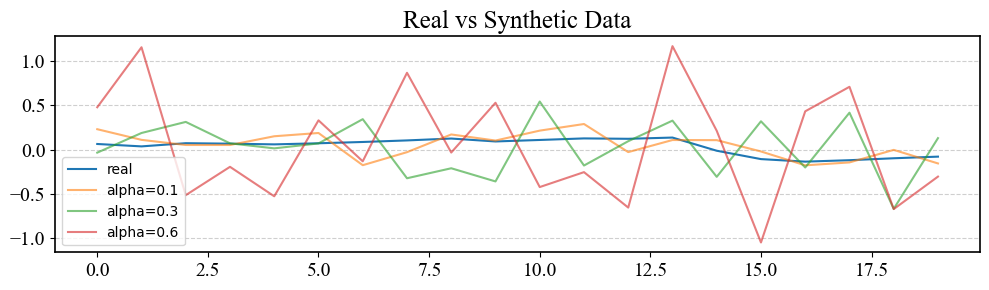

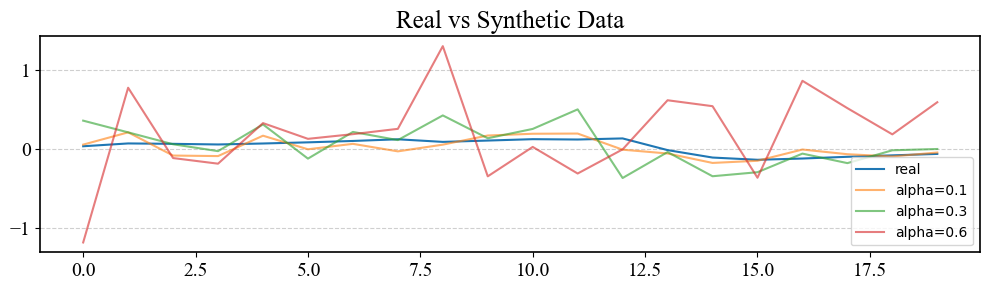

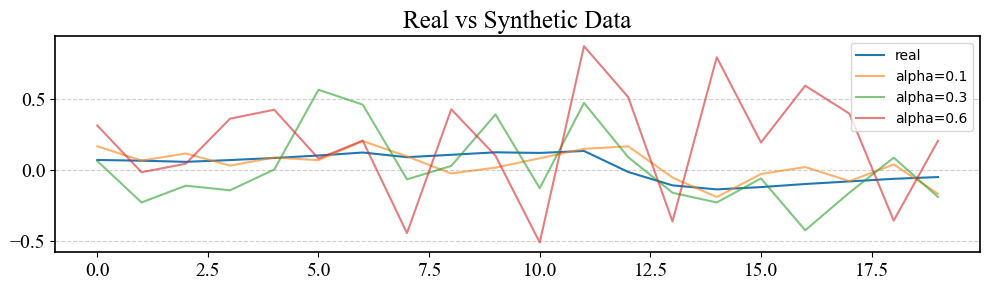

In [20]:
# let's plot a few realizations
for i in range(3):
    plot_real_and_synthetic(sequences[i], synthetic_data[:, i], alphas)


## Diversity

Do the generated samples cover the distribution of the real data?

To answer this question, a common approach is to apply t-SNE or PCA to both the original and synthetic datasets (after flattening the temporal dimension), see [TimeGAN](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf) work by Yoon et al. (2019) . Here we project the data into 2-dimensional space, allowing us to visually assess how closely the distribution of the generated samples resembles that of the real data.

### PCA

Below, we visualize the results of projecting both the real and synthetic data into 2D using PCA, for different levels of noise.

In [21]:
from genai4t.evaluation.generation.visualize import (visualize_2d_pca, visualize_2d_tsne)

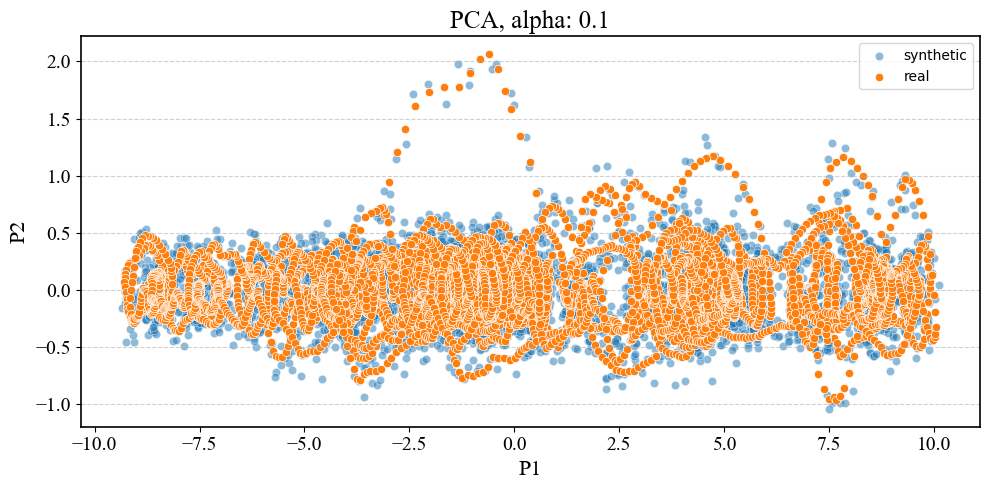

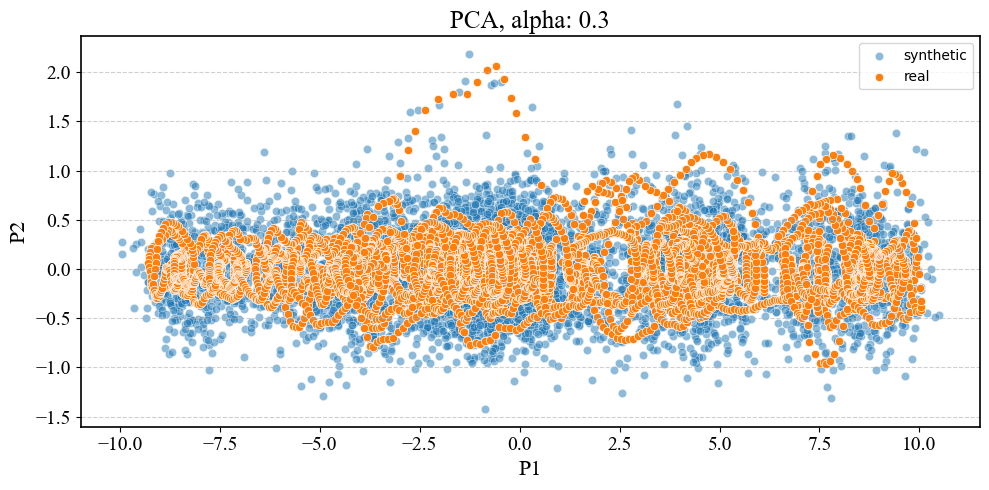

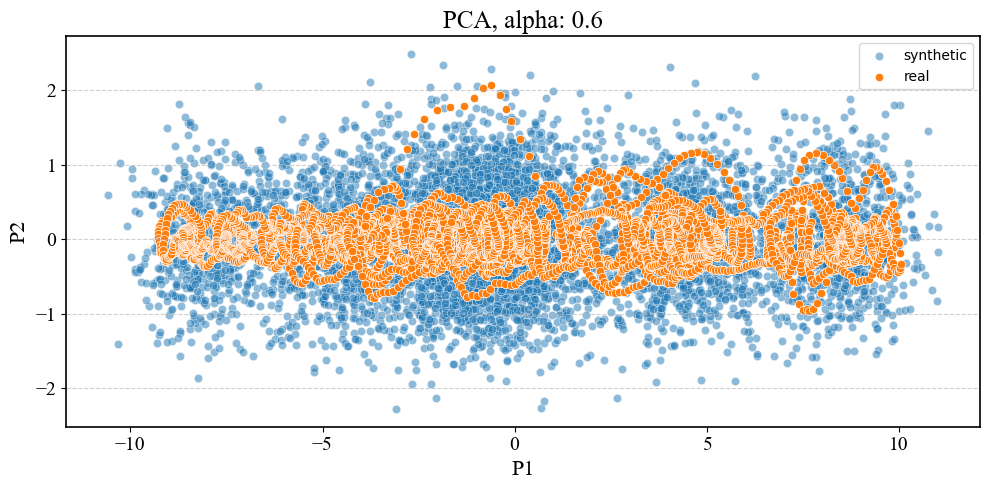

In [22]:
for i, alpha in enumerate(alphas):
    visualize_2d_pca(sequences, synthetic_data[i], title=f'PCA, alpha: {alpha:.1f}')

### TSNE
Below, we visualize the results of projecting both the real and synthetic data into 2D using t-SNE, for different levels of noise.

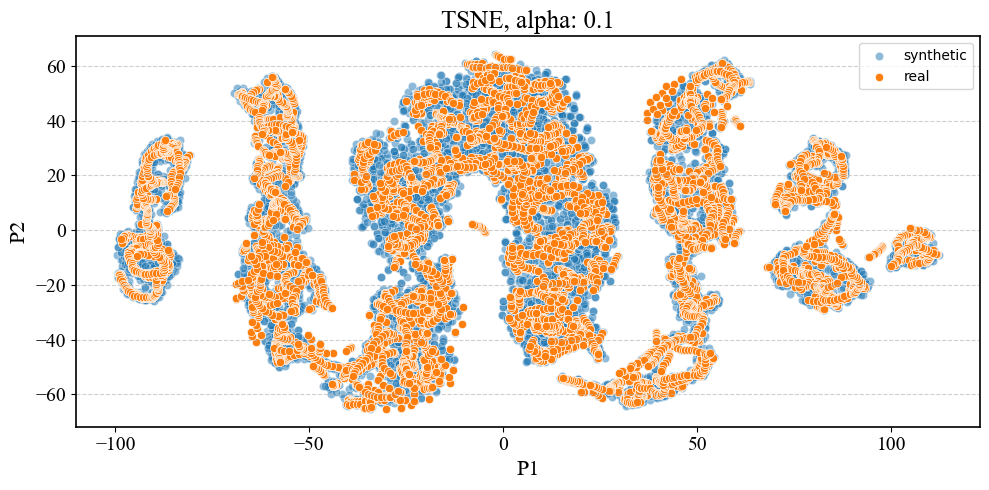

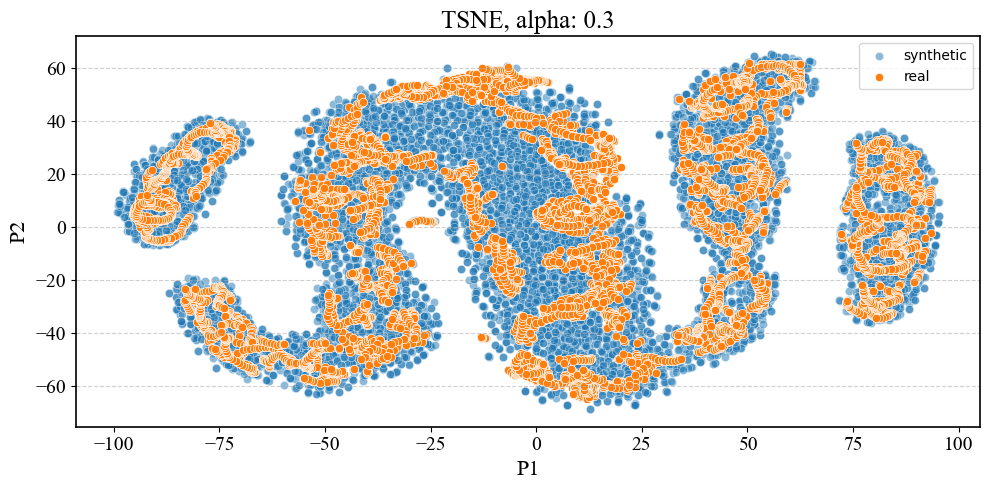

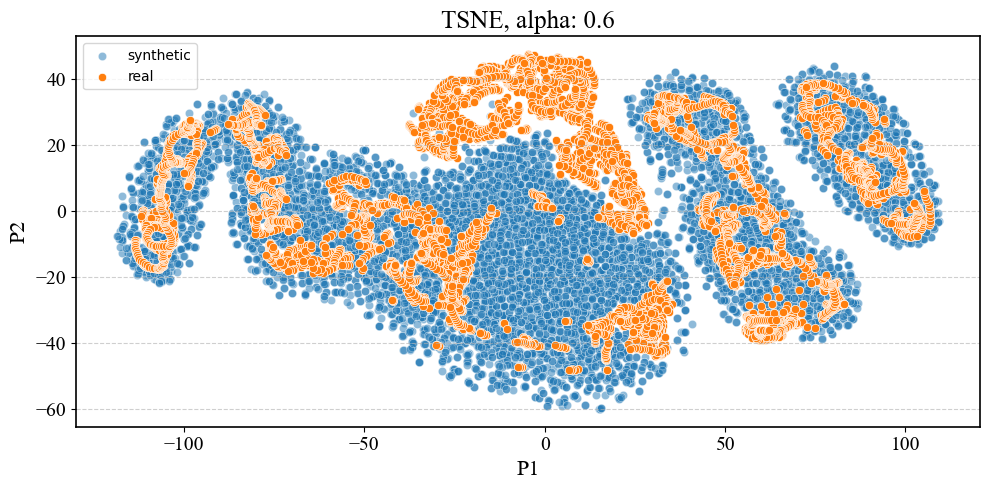

In [23]:
for i, alpha in enumerate(alphas):
    visualize_2d_tsne(sequences, synthetic_data[i], title=f'TSNE, alpha: {alpha:.1f}')

Nevertheless, this method also lacks a quantitative basis. Which takes us to the **Discriminative Score and Predictive Score**

## Discriminative Score (Fidelity): 

Here, we want to answer the question: Are the generated samples realistic and indistinguishable from real data?

Inspired by the approach used in GANs, we train a binary classifier to distinguish between real and synthetic data, once the generative model has been trained.

In this setup:

- Real data samples are labeled as real,
- Synthetic data samples are labeled as fake.

We then train a classifier to solve this binary classification task. If the classifier performs well, it means the synthetic data is significantly different from the real data. If the classifier struggles, it suggests that the synthetic data is indistinguishable from the real data. 



#### Classifier

We can use any classifier to implement this fidelity metric. For simplicity, we choose a single-layer `LSTM` architecture.

Note: Our goal here is not to find the best architecture or perform hyperparameter tuning—we use a simple model to demonstrate the concept.

Below is a snippet of the classifier implemented in PyTorch:

```python
class RNNClassifier(BaseLightningModule):
    def __init__(
        self,
        n_feat: int,
        hidden_dim: int,
        lr: float,
        output_dim: int  = 1,
        weight_decay: float = 0.):
        super().__init__(
            lr=lr,
            weight_decay=weight_decay)

        self.rnn = nn.LSTM(input_size=n_feat, hidden_size=hidden_dim, batch_first=True)
        self.mlp = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self._bce = nn.BCEWithLogitsLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hs, _ = self.rnn(x)
        # use only the last step
        last_hs = hs[:, -1, :]
        return self.mlp(last_hs)

    def step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        (x, y) = batch
        yhat = self.forward(x)
        loss = self._bce(yhat, y)
        return loss
```

In [24]:
# Import the DiscriminatorEvaluator class
# This evaluator trains a binary classifier to distinguish real vs. synthetic data.
from genai4t.evaluation.generation.discriminator import DiscriminatorEvaluator

In [25]:
# Initialize the evaluator with:
# - n_feat = 1: indicating univariate time series
# - random_state: for reproducibility
evaluator = DiscriminatorEvaluator(n_feat=1, random_state=ENV_CONFIG['random_state'])

In [26]:
# Dictionary to store  scores
_discriminative_scores = {}

# Loop through each alpha (noise level) and evaluate scores
for i, alpha in enumerate(alphas):
    _discriminative_scores[alpha] = evaluator.eval(
        sequences[..., np.newaxis],
        synthetic_data[i][..., np.newaxis]
    )

discriminative_scores = pd.DataFrame(_discriminative_scores).T.rename_axis('alpha')

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.6 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmp5_6426zy..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU availab

total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmp07azra66..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.6 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have ma

total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmpojjlcilu..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [27]:
discriminative_scores

,auc,precision,recall,f1,acc
alpha,,,,,
0.1,0.500103,0.500231,0.714663,0.588523,0.500330
0.3,0.540900,0.516397,0.696830,0.593197,0.522127
0.6,0.998971,0.983671,0.994716,0.989163,0.989102


As expected, as the noise level $\alpha$ increases, the discriminative model better differentiates real and synthetic data.

## Predictive score (Predictivity)

Synthetic data should be useful for downstream tasks.

To measure this, we train a regressor to predict the next value in a sequence using synthetic data generated by our generative model, once the generative model has been trained. Evaluation of the regressor is performed out-of-sample on real data. This approach is commonly referred to as "train on synthetic, test on real".

As a baseline for comparison, we also train a regressor using real data, allowing us to see how well the model trained on synthetic data performs relative to one trained on actual data

#### Regressor

We can use any regression model to solve this forecasting task. For simplicity, we choose a single-layer `LSTM` architecture.

Note: Our goal here is not to find the best architecture or perform hyperparameter tuning, we use a simple model to demonstrate the concept.

Below is a snippet of the regressor implemented in PyTorch:

```python

class RNNRegressor(BaseLightningModule):
    def __init__(
        self,
        n_feat: int,
        hidden_dim: int,
        lr: float,
        output_dim: int = 1,
        weight_decay: float = 0.):
        super().__init__(lr=lr, weight_decay=weight_decay)

        self.rnn = nn.LSTM(input_size=n_feat, hidden_size=hidden_dim, batch_first=True)
        self.mlp = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self._mse = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hs, _ = self.rnn(x)
        # use the last step
        last_hs = hs[:, -1, :]
        return self.mlp(last_hs)

    def step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        (x, y) = batch
        yhat = self.forward(x)
        loss = self._mse(yhat, y)
        return loss
```

In [28]:
# Import the PredictiveEvaluator class, which is used to evaluate how useful
# the synthetic data is for downstream forecasting tasks.
from genai4t.evaluation.generation.predictive import PredictiveEvaluator

In [29]:
# Initialize the predictive evaluator
# - random_state = 2024: for reproducibility
evaluator = PredictiveEvaluator(n_feat=1, random_state=2024)

In [30]:
# Dictionary to store scores
_predictive_scores = {}

In [31]:
# Evaluate baseline performance using real data for both training and testing
# This serves as a benchmark to compare synthetic data results
# alpha 0. is real data
_predictive_scores[0.] = evaluator.eval(sequences[..., np.newaxis], sequences[..., np.newaxis])

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.6 K  | train
1 | mlp  | Linear  | 25     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmps59kt4zt..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=1000` reached.


In [32]:
# Evaluate performance for each noise level (alpha)
# Train the regressor on synthetic data, test on real data
for i, alpha in enumerate(alphas):
    _predictive_scores[alpha] = evaluator.eval(
        sequences[..., np.newaxis],
        synthetic_data[i][..., np.newaxis]
    )

predictive_scores = pd.DataFrame(_predictive_scores).T.rename_axis('alpha')

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.6 K  | train
1 | mlp  | Linear  | 25     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/

total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmpfcvbs44e..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.6 K  | train
1 | mlp  | Linear  | 25     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai

total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmpage2coig..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.6 K  | train
1 | mlp  | Linear  | 25     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai

total_n_params: 2617
deleting /var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/tmpzwstvz2y..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [33]:
# Display the predictive scores 
predictive_scores

,MSE,MAE,MAPE
alpha,,,
0.0,0.003444,0.042215,73.189926
0.1,0.004295,0.048518,72.645319
0.3,0.007933,0.068310,89.979422
0.6,0.010538,0.081313,77.307445


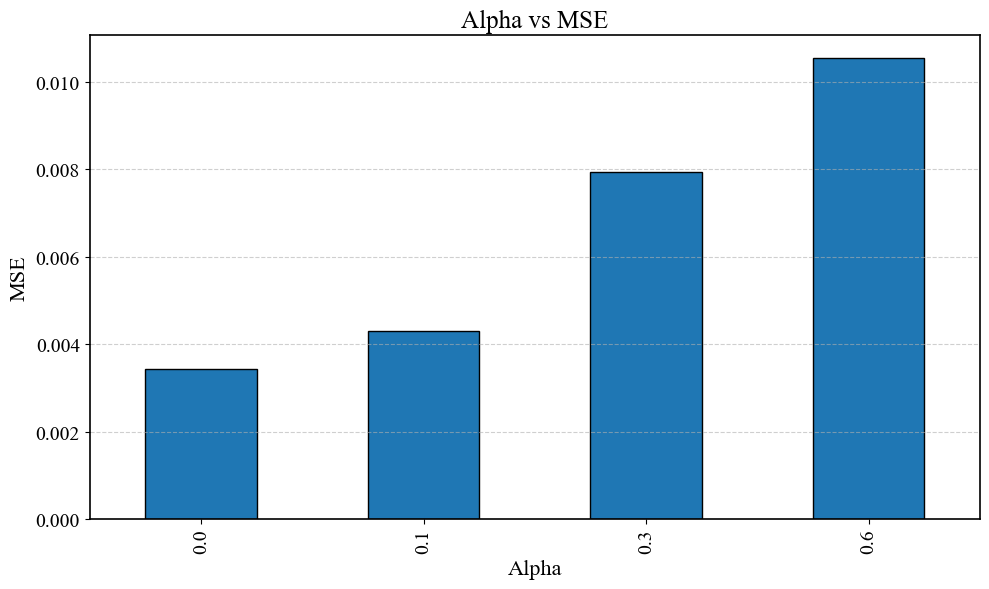

In [34]:
# Bar plot for MSE by alpha
fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))  

predictive_scores["MSE"].plot.bar(
    ax=ax,
    edgecolor='black'
)

# Set title and labels
ax.set_title("Alpha vs MSE")
ax.set_xlabel("Alpha")
ax.set_ylabel("MSE")

# Apply styling
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")